<a href="https://colab.research.google.com/github/AntonioCCosta/DPG_PhysicsBehavior_2026/blob/main/notebooks/notebook_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Physics of Behavior Tutorial II

In this session, we will focus on how to uncover long timescale properties of complex dynamical systems through a transfer operator approach.

Before we start, load the following python packages:

In [1]:
# Environment setup
!pip install -q -r https://raw.githubusercontent.com/AntonioCCosta/DPG_PhysicsBehavior_2026/main/requirements.txt

In [2]:
import os

if not os.path.exists("DPG_PhysicsBehavior_2026"):
    !git clone https://github.com/AntonioCCosta/DPG_PhysicsBehavior_2026.git
else:
    %cd DPG_PhysicsBehavior_2026
    !git pull
    %cd ..

import sys, platform
print("Python:", sys.version)
print("Platform:", platform.platform())

/content/DPG_PhysicsBehavior_2026
remote: Enumerating objects: 15, done.
remote: Counting objects: 100% (15/15), done.
remote: Compressing objects: 100% (9/9), done.
remote: Total 12 (delta 5), reused 0 (delta 0), pack-reused 0 (from 0)
Unpacking objects: 100% (12/12), 527.76 KiB | 2.39 MiB/s, done.
From https://github.com/AntonioCCosta/DPG_PhysicsBehavior_2026
   86e4823..ba713b3  main       -> origin/main
Updating 86e4823..ba713b3
Fast-forward
 notebooks/notebook_1.ipynb | 837 +++++++++++++++++----------------------------
 1 file changed, 321 insertions(+), 516 deletions(-)
/content
Python: 3.12.12 (main, Oct 10 2025, 08:52:57) [GCC 11.4.0]
Platform: Linux-6.6.113+-x86_64-with-glibc2.35


In [3]:
import h5py
import numpy as np
import numpy.ma as ma
sys.path.append('./DPG_PhysicsBehavior_2026/utils')
import operator_calculations as op_calc
import delay_embedding as embed
import partition_methods as cl
import coarse_graining as cgm
import matplotlib.pyplot as plt

## Stochastic dynamics on a 1d double well

We will start by a simple example, for which the long-lived dynamics can be derived analytically.

We will be considering overdamped Langevin dynamics on a potential landscape,

$$
\dot{x}(t) = -\partial_x V(x) + \sqrt{2 T_x}\,\eta(t),
\qquad \langle \eta(t)\eta(t') \rangle = \delta(t-t').
$$

Where the potential landscape is given by of a double well type:

$$
V(x) = \frac{x^4}{4} -\mu \frac{x^2}{2}
$$

Changing the sign of $\mu$ pushes the dynamics through a pitchfork bifurcation. You can check that yourself by finding the fixed points of the dynamics and their stability.

Let's gain intuition by making some simulations using a simpler Euler scheme


In [4]:
from numba import jit,prange
@jit(nopython=True, parallel=True)
def simulate_dw(x0s,mu, Tx, dt, max_iters,downsampling):
    n_sims = len(x0s)
    sims = np.zeros((n_sims, int(max_iters/downsampling)))
    for ks in prange(n_sims):
        x0 = x0s[ks]
        x = x0
        for i in range(max_iters):
            new_x = x + (-x**3+mu*x) * dt + np.sqrt(2 * Tx) * np.random.normal(0, np.sqrt(dt))
            x = new_x
            if i%downsampling==0:
                sims[ks, int(i/downsampling)] = x
    return sims

As you can see, depending on the value of $\mu$ the macroscopic properties of the dynamics change. When $\mu > 0$ we see two stable fixed points which traps the dynamics on a long timescale

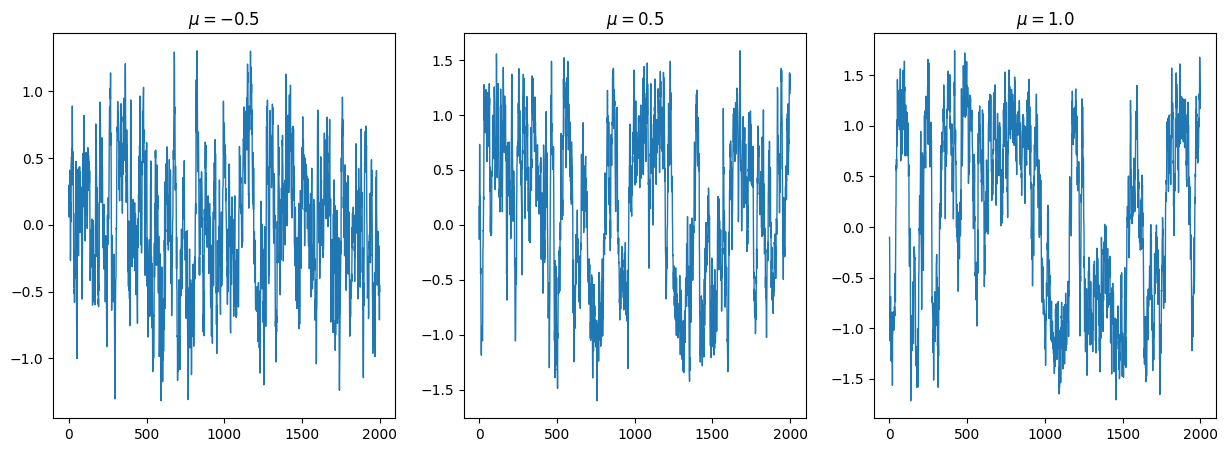

In [5]:

#set simulation parameters
Tx=2.5e-1 #temperature
T = 200
dt=1e-3
max_iters=int(T/dt)
final_dt = 1e-1
downsampling = int(final_dt/dt)

plt.figure(figsize=(15,5))
mu_vals = [-0.5,0.5,1]
for k in range(len(mu_vals)):
  mu=mu_vals[k]
  x0s = np.random.uniform(-1,1,1)
  sim = simulate_dw(x0s,mu, Tx, dt, max_iters,downsampling)[0]
  plt.subplot(1,3,k+1)
  plt.title(r'$\mu = {:.1f}$'.format(mu))
  plt.plot(sim,lw=1)
plt.show()

At large times, the system relaxes to the steady-state distribution, which in our case is given by the Boltzmann distribution. To see that, let's make more simualtions for a give value of mu

In [39]:

Tx=5e-1 #temperature
T = 1000
dt=1e-3
max_iters=int(T/dt)
final_dt = 1e-1
downsampling = int(final_dt/dt)
n_sims = 50
x0s = np.random.uniform(-1,1,n_sims)
mu=1
sims = simulate_dw(x0s,mu, Tx, dt, max_iters,downsampling)

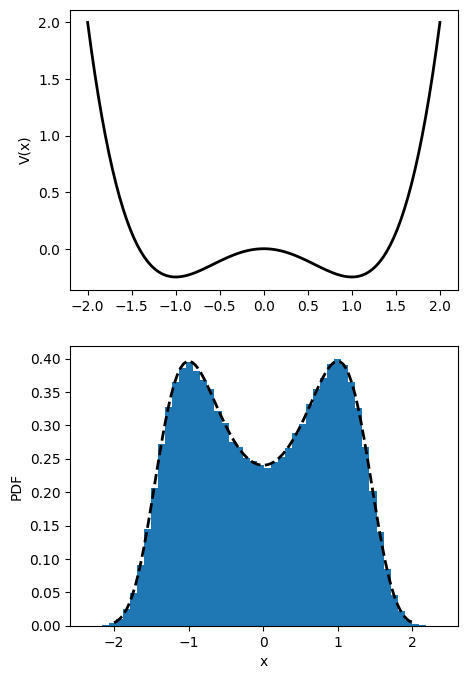

In [187]:
def potential(x,mu):
    return x**4 / 4 - mu * x**2 / 2

x = np.linspace(-2,2,100)
plt.figure(figsize=(5,8))
plt.subplot(2,1,1)
plt.plot(x,potential(x,mu),lw=2,c='k')
plt.ylabel('V(x)')
pB = np.exp(-potential(x,mu)/Tx)
Z = np.trapezoid(pB,x)
pB =pB/Z
plt.subplot(2,1,2)
plt.hist(np.hstack(sims),bins=50,density=True,label='sim')
plt.plot(x,pB,c='k',ls='--',lw=2,label='pB')
plt.xlabel('x')
plt.ylabel('PDF')
plt.show()

We can calculate this integral numerically, or approximate it analytically in the asymptotic limit

In [188]:
from scipy.interpolate import interp1d
from scipy.integrate import cumulative_trapezoid

def exppot(x, Tx,mu,sign=-1, fun=lambda z: 1):
    return np.exp(sign*potential(x,mu)/Tx)*fun(x)

def omega_be(Tx,mu):
    z = np.linspace(-20, 0, 1000)
    iarr = cumulative_trapezoid(exppot(z,Tx,mu), z, initial=0)
    ifun = interp1d(z, iarr)

    y = np.linspace(-1, 0, 1000)
    oarr = cumulative_trapezoid(exppot(y,Tx,mu, sign=1, fun=ifun), y, initial=0)/Tx
    ofun = interp1d(y, oarr)

    return 1/(2*ofun(0))


def transition_time_be(Tx,mu):
    z = np.linspace(-20, 0, 1000)
    iarr = cumulative_trapezoid(exppot(z,Tx,mu), z, initial=0)
    ifun = interp1d(z, iarr)

    y = np.linspace(-1, 0, 1000)
    oarr = cumulative_trapezoid(exppot(y,Tx,mu, sign=1, fun=ifun), y, initial=0)/Tx
    ofun = interp1d(y, oarr)

    return ofun(0)

In [189]:
transition_time_be(Tx,mu)

array(2.52163751)

In [190]:
def label_well(x, delta):
    lab = np.zeros_like(x, dtype=np.int8)
    lab[x > +delta] = +1
    lab[x < -delta] = -1
    return lab

In [191]:
def count_switches(x, mu, dt_sample):
    delta = 0.2 * np.sqrt(mu)
    state = label_well(x, delta)

    # remove barrier region
    mask = state != 0
    s = state[mask]

    # count sign flips
    flips = np.sum(s[1:] * s[:-1] < 0)

    T = len(x) * dt_sample
    return flips / T


In [192]:
count_switches(np.hstack(sims),mu,final_dt)

np.float64(0.32584)

In [193]:
omega_be(Tx,mu)*2

np.float64(0.3965677055402137)

In [194]:
def state_lifetime(states,tau):
    durations=[]
    for state in np.sort(np.unique(states.compressed())):
        gaps = states==state
        gaps_boundaries = np.where(np.abs(np.diff(np.concatenate([[False], gaps, [False]]))))[0].reshape(-1, 2)
        durations.append(np.hstack(np.diff(gaps_boundaries))*tau)
    return durations

In [195]:
delta = 0.2 * np.sqrt(mu)
xs = np.hstack(sims)
states = np.zeros_like(xs)
states[xs >  delta] = +1
states[xs < -delta] = -1
states = np.ma.masked_equal(states, 0)


In [196]:
states.shape

(500000,)

In [197]:
durs = np.hstack(state_lifetime(states,1))*final_dt

In [198]:
np.mean(durs[durs>2*final_dt]),transition_time_be(Tx,mu)

(np.float64(2.209360429758768), array(2.52163751))

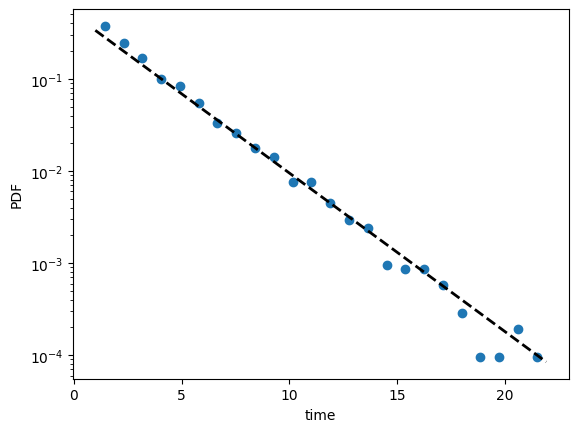

In [199]:
tmin=1
tmax=np.max(durs)
freqs,bin_edges = np.histogram(durs, bins=np.linspace(tmin,tmax,25), density=True)
centers = (bin_edges[1:]+bin_edges[:-1])/2
# plt.hist(durs, bins=np.linspace(tmin,tmax,10), density=True)
plt.scatter(centers,freqs,marker='o')
times = np.linspace(tmin,tmax,10)
plt.plot(times,5e-1*np.exp(-times/transition_time_be(Tx,mu)),c='k',lw=2,ls='--')
plt.yscale('log')
plt.ylabel('PDF')
plt.xlabel('time')
plt.show()

# Extracting slow modes through a transfer operator picture of the dynamics

As we've seen above, in this simple case most properties of the dynamics can be directly evaluated analytically. However, in many complex systems (as we'll see below), the long-lived properties of the dynamics are not immediately apparent from the equations, and analytical solutions are challenging to obtain.

To access the long-lived properties of the dynamics more directly, we will make use of an equivalent representation of the dynamics in terms of a transfer operator for the evolution of probability distributions in the state space.

From the above Langevin dynamics, we can write the Fokker-Planck equation for the density $\rho$ dynamics,

$$
\dot{\rho}(t) = \partial_x\left(\partial_x V(x) \rho(t) \right) + T_x\partial_x^2 \rho(t),
$$

which we can rewrite as,

$$
\dot{\rho}(t) = L \rho(t)
$$

where $L = \partial_x\left(\partial_x V(x) \cdot \right) + T_x\partial_x^2\cdot$, is the forward Fokker-Planck operator, a linear operator that determines the evolution of probability distributions in the state space driven by the nonlinear Langevin dynamics encoded in $V(x)$.

## Finite-difference estimator of the transfer operator

We can numerically approximate $L$ through a finite-difference estimator. Here, we will make use of the Chang-Cooper method (Change, Cooper. *A Practical Difference Scheme for Fokker-Planck Equations*. J. Comput. Physics 1969)

In [200]:
import scipy.sparse as sp
import scipy.sparse.linalg as spla


def fokker_planck_L_sg(x, mu, Tx, tau_x=1.0, boundary="reflecting",potential=None):
    """
    Build L for ∂_t p = ∂_x(∂_x V p) + Tx ∂_x^2 p on a uniform grid x (Chang-Cooper).
    Pass exactly one of:
      - potential(x): callable returning V(x)
    """
    x = np.asarray(x); N = x.size
    dx = x[1] - x[0]; D = Tx

    # Bernoulli function
    def B(z):
        out = np.empty_like(z)
        small = np.abs(z) < 1e-8
        out[~small] = z[~small] / np.expm1(z[~small])
        zS = z[small]
        out[small] = 1 - zS/2 + zS**2/12
        return out

    V = potential(x,mu)
    dV_face = V[1:] - V[:-1]
    psi = -(dV_face) / D

    a = (D / dx**2) * B(psi)      # coeff to node i+1 from face i+1/2
    b = (D / dx**2) * B(-psi)     # coeff to node i   from face i+1/2

    diag  = np.zeros(N)
    upper = np.zeros(N-1)
    lower = np.zeros(N-1)

    # interior
    diag[1:-1]  = -(b[1:] + a[:-1])
    upper[1:-1] =  a[1:-1]
    lower[0:-1] =  b[0:-1]

    if boundary == "reflecting":
        diag[0]   = -b[0];   upper[0]  =  a[0]
        diag[-1]  = -a[-1];  lower[-1] =  b[-1]; upper[-1] =  a[-1]
    elif boundary == "absorbing":
        diag[0] = upper[0] = 0.0
        diag[-1] = lower[-1] = 0.0
        lower[0] = 0.0
        upper[-1] = 0.0
    else:
        raise ValueError("boundary must be 'reflecting' or 'absorbing'")

    L = sp.diags([lower, diag, upper], offsets=[-1,0,1], format="csc")
    return (1.0/tau_x)*L

In [201]:
N = 1000
Tx=5e-1
mu=1.
x_min, x_max = -np.sqrt(np.abs(mu))-2*np.sqrt(Tx),np.sqrt(np.abs(mu))+2*np.sqrt(Tx)
x = np.linspace(x_min, x_max, N)
tau_x=1
delay=1e-1
V = lambda x,mu: x**4 / 4 - mu * x**2 / 2

L_fp = fokker_planck_L_sg(x,mu,Tx,tau_x,potential=V)

Now we can directly simulate the dynamics of the entire probability distribution function, rather than a single trajectory. For example, starting from a delta function, we can evolve the dynamics by taking,

$$
\rho(t+\tau) = P_\tau \rho(t),
$$

where $P_\tau = e^{L \tau}$ is the discrete time transition matrix, also known as the forward propagator.



In [202]:
print('Obtain transition matrix')
P_tau = spla.expm(delay * L_fp)

print('Iterate probability distribution function')
p0 = np.zeros(P_tau.shape[0]) # set initial condition as a delta function
p0[200] = 1
n_iters=100
p=p0
ps=np.zeros((n_iters,p.shape[0]))
ps[0]=p
for k in range(1,n_iters): #iterate the dynamics
    p = P_tau @ p
    ps[k]=p

Obtain transition matrix
Iterate probability distribution function


You can now observe the relaxation of the probability distribution to the steady state, which we now is given by the Boltzmann distribution

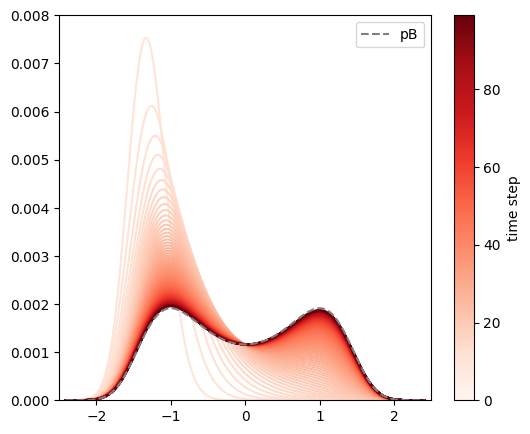

In [203]:
import matplotlib as mpl

ds = 1
n = int(len(ps)/ds)
colors_c = plt.cm.Reds(np.linspace(0.1, 1, n))

plt.figure(figsize=(6,5))
for k, k_ in enumerate(np.arange(1, len(ps), ds)):
    p = ps[k_]
    plt.plot(x, p, c=colors_c[k])

plt.xlim(-2.5, 2.5)
plt.ylim(0, 0.008)

norm = mpl.colors.Normalize(vmin=0, vmax=n-1)
sm = mpl.cm.ScalarMappable(cmap=plt.cm.Reds, norm=norm)
sm.set_array([])

ax = plt.gca()
cbar = plt.colorbar(sm, ax=ax)
cbar.set_label("time step")
pB = np.exp(-V(x,mu)/Tx)
pB = pB/np.sum(pB)
plt.plot(x,pB,c='gray',ls='--',label='pB')
plt.legend()
plt.show()


In [204]:
## For an animation uncomment this code

# import matplotlib.animation as animation
# from IPython.display import HTML
# import matplotlib as mpl

# ds = 1
# frames = np.arange(1, len(ps), ds)

# fig, ax = plt.subplots(figsize=(6,5))

# line, = ax.plot([], [], lw=2)
# line_B, = ax.plot([], [], c='gray', ls='--', label='pB')

# ax.set_xlim(-1.8, 1.8)
# ax.set_ylim(0, 0.014)
# ax.set_xlabel("x")
# ax.set_ylabel("p(x,t)")

# # Boltzmann reference
# pB = np.exp(-V(x,mu)/Tx)
# pB = pB / np.sum(pB)
# line_B.set_data(x, pB)

# # Color map
# cmap = plt.cm.Reds
# norm = mpl.colors.Normalize(vmin=0, vmax=len(frames))

# def init():
#     line.set_data([], [])
#     return line, line_B

# def animate(i):
#     p = ps[frames[i]]
#     line.set_data(x, p)
#     line.set_color(cmap(norm(i)))
#     ax.set_title(f"time step = {frames[i]}")
#     return line, line_B

# ani = animation.FuncAnimation(
#     fig, animate, init_func=init,
#     frames=len(frames), interval=30, blit=True
# )

# plt.close(fig)

# HTML(ani.to_jshtml())


## Decomposing the dynamics into it's long-lived modes

The Fokker-Planck operator, as well as it's discrete time propagator, share important eigenvalue and eigenvector properties. In particular, the eigenvalues of $L$, $\Lambda_k$ are related to those of $P_\tau$, $\lambda_k$. Indeed, since $P_\tau = e^{L \tau}$ the eigenvalue decomposition yields,

$P_\tau \psi_k = \lambda_k \psi_k = e^{\Lambda_k \tau} \psi_k$, and so $\lambda_k = e^{\Lambda_k \tau}$.


$P_\tau$ always has an eigenvector of eigenvalue 1, which corresponds to the steady-state distribution since it's unchanged when acted by $P_\tau$,

$P_\tau \pi = \pi$. Let's see what that looks like

In [205]:
eigvals_fwd,eigvecs_fwd = op_calc.sorted_spectrum(P_tau,k=5)
pi = eigvecs_fwd[:,0].real/eigvecs_fwd[:,0].real.sum()

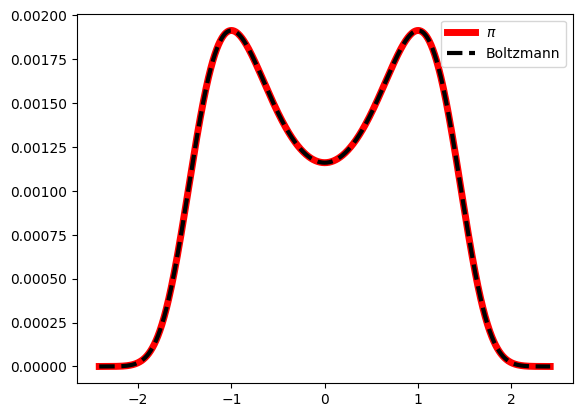

In [206]:
plt.plot(x,pi,c='r',lw=5,label=r'$\pi$')
plt.plot(x,pB,c='k',ls='--',lw=3,label='Boltzmann')
plt.legend()
plt.show()

So the first right eigenvector of $P_\tau$ corresponds to the steady-state distribution. The remaining eigenvectors decay to the steady-state distribution on a timescale given by

$$
\Lambda^{-1}_k = -\frac{\tau}{\log \lambda_k}.
$$

In this case, the slowest non-trivial mode corresponds to the time it takes to escape a potential well.

This can be approximated through the theory of first passage times (see e.g. Pavliotis *Stochastic Processes and Applications* 2014).

Let's consider that the particle starts at a minimum of the potential well $x_0=a$ and escapes when reaching the barrier situated at $x_f = b$. Assuming reflective boundary conditions at $x_0=a$ and an absorbing boundary at $x_f=b$ (where the escape events occurs), we have,

$$
\overline{\tau}(x_0) = \frac{1}{\tau_x T_x} \int_{x_0}^b e^{V(y)/T_x}dy \int_a^y  e^{-\beta V(z)/T_x} dz.
$$



In [207]:
from scipy.interpolate import interp1d
from scipy.integrate import cumulative_trapezoid

def exppot(x, Tx,mu,sign=-1, fun=lambda z: 1):
    return np.exp(sign*potential(x,mu)/Tx)*fun(x)

def omega_be(Tx,mu):
    z = np.linspace(-5*np.sqrt(mu), 0, 5000)
    iarr = cumulative_trapezoid(exppot(z,Tx,mu), z, initial=0)
    ifun = interp1d(z, iarr)

    y = np.linspace(-1, 0, 5000)
    oarr = cumulative_trapezoid(exppot(y,Tx,mu, sign=1, fun=ifun), y, initial=0)/Tx
    ofun = interp1d(y, oarr)

    return 1/(ofun(0))

In [208]:
1/omega_be(Tx,mu),-delay/np.log(eigvals_fwd[1].real)

(np.float64(2.521704051528973), np.float64(2.3643763486732423))

The left eigenvectors of the operator $\phi_1$ capture directions in the state-space that communicate the least: parts of the state space that follow each other in time have similar $\phi_1$ values, whereas parts of the state space for which is takes a long time to transition between have different values of $\phi_1$.

In [209]:
_,eigvecs_bw = op_calc.sorted_spectrum(P_tau.T,k=5)

eigvecs_bw = eigvecs_bw.real
eigvecs_bw = eigvecs_bw/np.linalg.norm(eigvecs_bw,axis=0)

phi2 = eigvecs_bw[:,1]

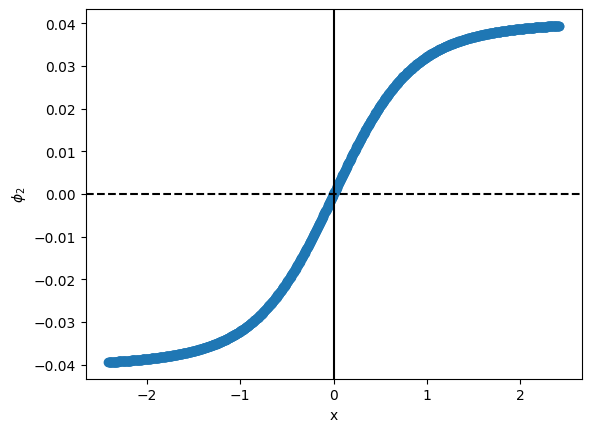

In [210]:
plt.scatter(x,phi2)
plt.axvline(0,c='k')
plt.axhline(0,c='k',ls='--')
plt.ylabel(r'$\phi_2$')
plt.xlabel('x')
plt.show()

More generally, in systems for which the location of the border between metastable states or almost invariant sets is not immediately apparent from the equations of motion, we can still use the structure of the inferred transfer operator to identify such regions.

We call a set $S$ coherent when the system is more likely to remain within the set than it is to leave it within a time $\tau$. We quantify this intuition through

$$
\chi_{\mu,\tau}(S) = \frac{\mu(S\cap \Phi_{-\tau}S)}{\mu(S)} = \frac{\mu(\Phi_\tau S\cap S)}{\mu(S)},
$$

where $\mu$ is the invariant measure preserved by the invertible flow $\Phi_\tau$. Given an inferred transfer operator $P_\tau$ and its associated stationary eigenvector $\pi$, we can immediately compute $\chi$ as

$$
\chi_{\pi,\tau}(S) = \frac{\sum_{i,j\in S}\pi_i P_{ij}(\tau)}{\sum_{i \in S} \pi_i}.
$$

It turns out that the second eigenvector of the reversibilized transfer operator $\phi_2$ provides an optimal subdivision of the state space into almost invariant sets (see Froyland et al Physica D 2005). And so instead of a brute force search for the sets that maximize the coherence, we can search along $\phi_2$ for a maximum of the overall coherence of both sets,
$$
\chi(\phi_2^c) = \text{min}\{\chi_{\pi,\tau^*}(S^+(\phi_2^c)),\chi_{\pi,\tau^*}(S^-(\phi_2^c))\}
$$

where $\{S^+(\phi_2^c),S^-(\phi_2^c)\}$ result from a partition at $\phi_2^c$.

In [211]:
cr,rho_sets,ms,idx,km_labels = cgm.optimal_partition(phi2,pi,P_tau.T,return_rho=True)

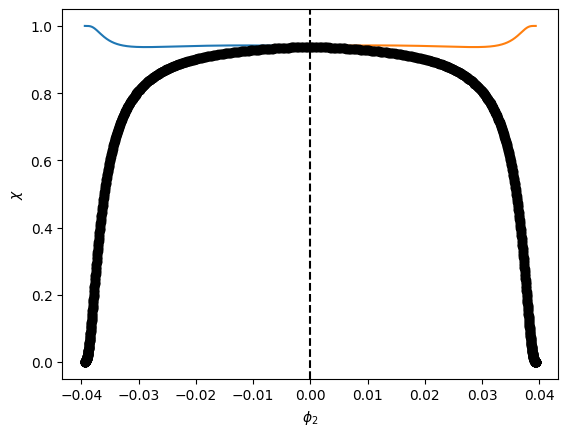

In [212]:
plt.plot(cr,rho_sets)
plt.plot(cr,np.min(rho_sets,axis=1),marker='o',c='k')
plt.axvline(cr[idx],c='k',ls='--')
plt.ylabel(r'$\chi$')
plt.xlabel(r'$\phi_2$')
plt.show()

## Estimating the transition matrix from data

In the calculations above, we directly used the analytical expression to solve the Fokker-Planck equation using a finite-difference approach. However, in most real world scenarios, the equations of motion are unavailable, and instead we only have access to a finite set of observations. How then can we still obtain the long-lived modes of the dynamics?

Notice that $P_\tau$ estimated above provides the transition probability among state space regions. The simplest way to estimate that from time series data, is to simply parition the domain and count transitions among state space regions. This is called the Ulam-Galerkin method.

Technically speaking, the Galerkin projection takes the infinite dimensional operator onto an $N\times N$ operator of finite rank by truncating an infinite dimensional set of basis functions at a finite $N$. Ulam's method uses characteristic functions as the basis for this projection,

$$
\zeta_i(x) = \begin{cases}
    1, & \text{for $x \in s_i$}\\
    0, & \text{otherwise}
    \end{cases}.
$$

We thus partition the space into $N$ connected sets with nonempty and disjoint interior that covers $M$: $M = \cup_{i=1}^N s_i$, and approximate the transfer operator as a Markov chain by counting transitions from $s_i$ to $s_j$ in a finite time $\tau$. Given T observations, a set of $N$ partitions, and a transition time $\tau$, we compute

$$
C_{ij}(\tau) = \sum_{t=0}^{T-\tau}\zeta_i(x(t))\zeta_j(x(t+\tau))
$$

The maximum likelihood estimator of the transition matrix is obtained by simply row normalizing the count matrix,

$$
P_{ij}(\tau) = \frac{C_{ij}(\tau)}{\sum_j C_{ij}(\tau)}.
$$

Let's see how that works for our simulations. To partition the state-space into Voronoi cells, we will use the k-means algorithm to identify $N$ clusters that minimize the within cluster variances


In [213]:
N=1000
#labels_all is an array with the partition that each point in the time series belongs to
#centers is the centroid of each k-means cluster
labels_all,centers = cl.kmeans_partition(ma.hstack(sims).reshape(-1,1),N,batchsize=50000,return_centers=True)

To emulate the calculation from above, we take a delay of 1 frame (0.1s) and estimate the transition matrix by counting. As we can see, the implied timescales, estimates as $|\Lambda|_k^{-1} = -\tau/\log(\lambda_k(\tau))$ match the transition time as obtained analytically above

In [214]:
delay=1
P_emp = op_calc.transition_matrix(labels_all,delay)
eigvals_emp,eigvecs_emp = op_calc.sorted_spectrum(R,k=5)
timp=-delay*final_dt/np.log(eigvals_emp[1].real)

print('estimated timescale: {:.4f}'.format(timp))

print('analytical timescale: {:.4f}'.format(transition_time_be(Tx,mu)))

estimated timescale: 2.3797
analytical timescale: 2.5216


We can now proceed as above, and find the location of the potential energy barrier by calculating the coherence of each set along $\phi_2$, which should resemble the eigenvector calculated above with the analytical operator (up to a sign flip)

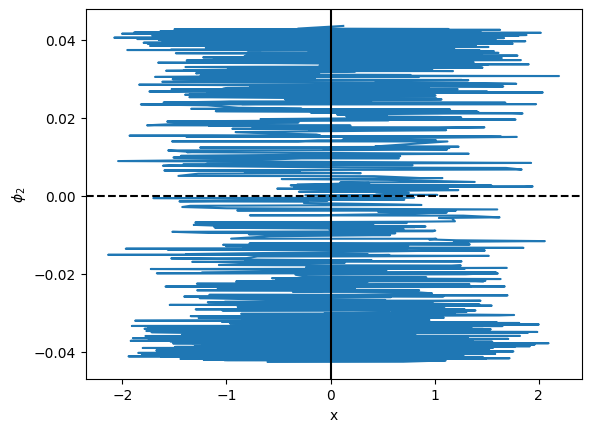

In [218]:
eigvecs_emp = eigvecs_emp.real
eigvecs_emp = eigvecs_emp/np.linalg.norm(eigvecs_emp,axis=0)
phi2_emp = eigvecs_emp[:,1]
sorted_indices = np.argsort(phi2_emp)
plt.plot(centers[sorted_indices],phi2_emp[sorted_indices])
plt.ylabel(r'$\phi_2$')
plt.xlabel('x')
plt.axvline(0,c='k')
plt.axhline(0,c='k',ls='--')
plt.show()


In [216]:
inv_measure_emp = op_calc.stationary_distribution(P_emp)
cr,rho_sets,ms,idx,km_labels = cgm.optimal_partition(phi2_emp,inv_measure_emp,P_emp,return_rho=True)

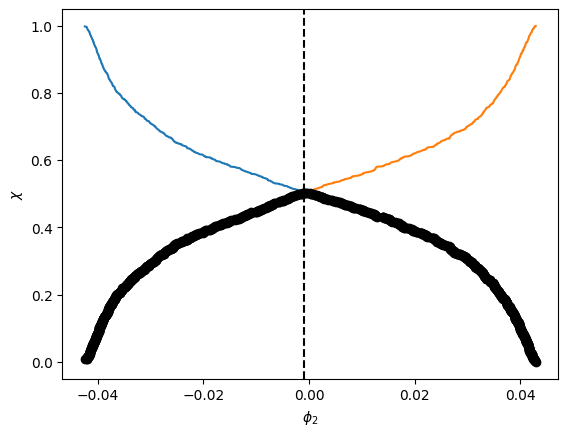

In [217]:
plt.plot(cr,rho_sets)
plt.plot(cr,np.min(rho_sets,axis=1),marker='o',c='k')
plt.axvline(cr[idx],c='k',ls='--')
plt.ylabel(r'$\chi$')
plt.xlabel(r'$\phi_2$')
plt.show()

# Extending to a (slightly) more complex system

for which the longest timescales are not immediate obvious. To do that, we will now move onto a chaotic dynamical system, and see how these ideas generalize beyond the equilibrium example shown above.

Take the Lorenz equations, a canonical example of the transition to chaos in three dimensional nonlinear dynamics:

$$
\begin{cases}
\dot{x} = \sigma (y - x), \\
\dot{y} = x(\rho - z) - y, \\
\dot{z} = xy - \beta z.
\end{cases}
$$

with $\rho=28$, $\sigma=10$ and $\beta = 8/3$. In this regime, the dynamics is chaotic, and the system relaxes to the iconic butterfly attractor. Let's check a simulations.

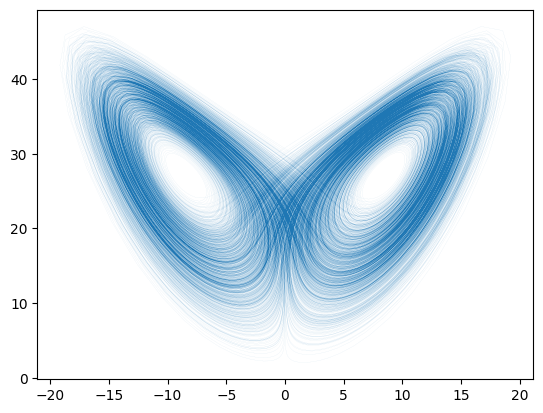

In [141]:
from scipy.integrate import odeint

def Lorenz(state,t,sigma,rho,beta):
    # unpack the state vector
    x,y,z = state
    # compute state derivatives
    xd = sigma * (y-x)
    yd = (rho-z)*x - y
    zd = x*y - beta*z
    # return the state derivatives
    return [xd, yd, zd]

dt = 0.02
frameRate=1/dt
T = 2000
discard_T = 500
T_total = T+discard_T
state0 = np.array([-8, -8, 27])
t = np.linspace(0, T_total, int(T_total*frameRate))
sigma,rho,beta=10,28,8/3
tseries=np.array(odeint(Lorenz,state0,t,args=(sigma,rho,beta)),dtype=np.float64)[int(discard_T/dt):]

plt.plot(tseries[:,0],tseries[:,2],lw=.02)
plt.show()

Unlike the overdamped Langevin dynamics in a double well, where the long-term dynamics are dictated by the gradient of a potential landscape, here is it less obvious to determine what the slow modes of the dynamics are. In addition, while for the 1d example above we could directly obtain a finite difference approximation of the Fokker-Planck operator, here we need to derive directly from the time series observations.

The simplest way to do that is to partition the state space into small boxes, $s_i$, $i={1,\ldots,N}$ and approximate the discrete time transfer operator by counting the transition among such boxes, $P_{ij} = p(s_j(t+\tau)|s_i(t))$. This approach is called an Ulam-Galerkin method.

More technically, the Galerkin projection takes the infinite dimensional operator onto an $N\times N$ operator of finite rank by truncating an infinite dimensional set of basis functions at a finite $N$. Ulam's method uses characteristic functions as the basis for this projection,

$$
\zeta_i(x) = \begin{cases}
    1, & \text{for $x \in s_i$}\\
    0, & \text{otherwise}
    \end{cases}.
$$

Here, we will implicitly define our characteristic functions through a k-means discretization of the space. We thus partition the space into $N$ connected sets with nonempty and disjoint interior that covers $M$: $M = \cup_{i=1}^N s_i$, and approximate the operator as a Markov chain by counting transitions from $s_i$ to $s_j$ in a finite time $\tau$. Given T observations, a set of $N$ partitions, and a transition time $\tau$, we compute

$$
C_{ij}(\tau) = \sum_{t=0}^{T-\tau}\zeta_i(x(t))\zeta_j(x(t+\tau))
$$

The maximum likelihood estimator of the transition matrix is obtained by simply row normalizing the count matrix,

$$
P_{ij}(\tau) = \frac{C_{ij}(\tau)}{\sum_j C_{ij}(\tau)}
$$
